In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr

import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from utils import *

get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
class SpatialGP(ExactGP):
    """
    GP with shared hyperparameters that includes lat/lon as features.
    Features: [CO2, CH4, lat, lon] -> allows spatial variation in predictions.
    """
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        
        # Separate kernels for forcing vs spatial dimensions
        # Forcing kernel (CO2, CH4) - dims 0, 1
        self.covar_forcing = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=2, active_dims=[0, 1]))
        # Spatial kernel (lat, lon) - dims 2, 3
        self.covar_spatial = ScaleKernel(RBFKernel(ard_num_dims=2, active_dims=[2, 3]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        # Product kernel: forcing * spatial (captures interaction)
        covar_x = self.covar_forcing(x) * self.covar_spatial(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

In [5]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370", "hist-aer", "hist-GHG"]
X_train_xr, X_length = prepare_predictor(train_files, train_path)
y_train_xr, y_length = prepare_predictand(train_files, train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path, time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245', data_path=test_path, time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/home/jovyan/repos/EAEE4000_ML_EnvEng/Tutorials/utils.py:68: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'member' ('member',) The recommendation is to set join explicitly for this case.
  Y = xr.concat(Y_all,dim='time').mean('member')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
X_train_df = pd.DataFrame({
    "CO2": X_train_xr["CO2"].data,
    "CH4": X_train_xr["CH4"].data
}, index=X_train_xr["CO2"].coords['time'].data)

X_test_df = pd.DataFrame({
    "CO2": X_test_xr["CO2"].data,
    "CH4": X_test_xr["CH4"].data
}, index=X_test_xr["CO2"].coords['time'].data)

y_train_df = y_train_xr["tas"].stack({"stacked": ("latitude", "longitude")})
y_train_df = pd.DataFrame(y_train_df.to_pandas())

# Standardize the predictors
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df = (X_train_df - mean) / std
X_test_df = (X_test_df - mean) / std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

In [7]:
# Standardize the predictand
y_train = y_train_df.to_numpy().astype(np.float64)
train_tas_mean, train_tas_std = y_train.mean(), y_train.std()
y_train = (y_train - train_tas_mean) / train_tas_std

print(X_train.shape, y_train.shape, X_test.shape)

(753, 2) (753, 13824) (86, 2)


In [8]:
# Get lat/lon from your xarray data
lat = y_train_xr.latitude.values  # (96,)
lon = y_train_xr.longitude.values  # (144,)

# Prepare training data with spatial features
X_train_spatial, y_train_spatial, lat_flat, lon_flat = prepare_spatial_data(
    X_train, y_train, lat, lon, n_subset=15000
)

# Standardize lat/lon (important for kernel learning)
lat_mean, lat_std = lat_flat.mean(), lat_flat.std()
lon_mean, lon_std = lon_flat.mean(), lon_flat.std()

X_train_spatial[:, 2] = (X_train_spatial[:, 2] - lat_mean) / lat_std
X_train_spatial[:, 3] = (X_train_spatial[:, 3] - lon_mean) / lon_std

print(f"Training data shape: {X_train_spatial.shape}")

# Convert to tensors
X_train_t = torch.tensor(X_train_spatial, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_spatial, dtype=torch.float32).to(device)

# Initialize model
likelihood = GaussianLikelihood().to(device)
model = SpatialGP(X_train_t, y_train_t, likelihood).to(device)

Training data shape: (15000, 4)


In [9]:
# Train
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = -mll(output, y_train_t)
    loss.backward()
    optimizer.step()
    if (i + 1) % 20 == 0:
        print(f"Iter {i+1}/{n_iter} - Loss: {loss.item():.3f}")

# Print learned hyperparameters
print(f"\nLearned hyperparameters:")
print(f"  Forcing lengthscales: {model.covar_forcing.base_kernel.lengthscale.detach().cpu().numpy()}")
print(f"  Spatial lengthscales: {model.covar_spatial.base_kernel.lengthscale.detach().cpu().numpy()}")
print(f"  Noise: {likelihood.noise.item():.4f}")

Iter 20/100 - Loss: 0.510
Iter 40/100 - Loss: 0.784
Iter 60/100 - Loss: 0.621
Iter 80/100 - Loss: 0.648
Iter 100/100 - Loss: 0.674

Learned hyperparameters:
  Forcing lengthscales: [[0.82545125 4.715413  ]]
  Spatial lengthscales: [[0.31040186 0.42550611]]
  Noise: 0.0676


In [10]:
model.eval()
likelihood.eval()

# Prepare full test grid
X_test_spatial = prepare_test_spatial(X_test, lat_flat, lon_flat)
X_test_spatial[:, 2] = (X_test_spatial[:, 2] - lat_mean) / lat_std
X_test_spatial[:, 3] = (X_test_spatial[:, 3] - lon_mean) / lon_std

n_test_time = X_test.shape[0]
n_space = len(lat_flat)

# Predict in chunks to avoid memory issues
chunk_size = 5000
n_chunks = (X_test_spatial.shape[0] + chunk_size - 1) // chunk_size

pred_means = []
pred_vars = []

print(f"\nPredicting {X_test_spatial.shape[0]} points in {n_chunks} chunks...")

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, X_test_spatial.shape[0])
        
        X_chunk = torch.tensor(X_test_spatial[start:end], dtype=torch.float32).to(device)
        pred = likelihood(model(X_chunk))
        pred_means.append(pred.mean.cpu().numpy())
        pred_vars.append(pred.variance.cpu().numpy())
        
        if (i + 1) % 50 == 0:
            print(f"  Chunk {i+1}/{n_chunks}")

# Concatenate and reshape
pred_mean_flat = np.concatenate(pred_means)  # (n_test_time * n_space,)
pred_var_flat = np.concatenate(pred_vars)

# Reshape to (n_test_time, n_space) then to (n_test_time, n_lat, n_lon)
posterior_mean_standard = pred_mean_flat.reshape(n_test_time, n_space)
posterior_var_standard = pred_var_flat.reshape(n_test_time, n_space)

# Inverse standardization
posterior_mean = posterior_mean_standard * train_tas_std + train_tas_mean
posterior_std = np.sqrt(posterior_var_standard) * train_tas_std

print(f"Final prediction shape: {posterior_mean.shape}")


Predicting 1188864 points in 238 chunks...
  Chunk 50/238
  Chunk 100/238
  Chunk 150/238
  Chunk 200/238
Final prediction shape: (86, 13824)


In [11]:
y_test_pre_mean = np.reshape(posterior_mean, [posterior_mean.shape[0], 96, 144])
y_test_pre_std = np.reshape(posterior_std, [posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(
    coords={
        'time': X_test_xr.time.values,
        'latitude': X_test_xr.latitude.values,
        'longitude': X_test_xr.longitude.values
    },
    data_vars=dict(
        tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
        tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)
    )
)


In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.4512051661346242
RMSE at 2100: 0.6747573004944168
RMSE 2045-2055: 0.48319891827479294
RMSE 2090-2100: 0.707224241297542
RMSE 2050-2100: 0.5974554644018982
RMSE average last 20y: 0.6010618027547004


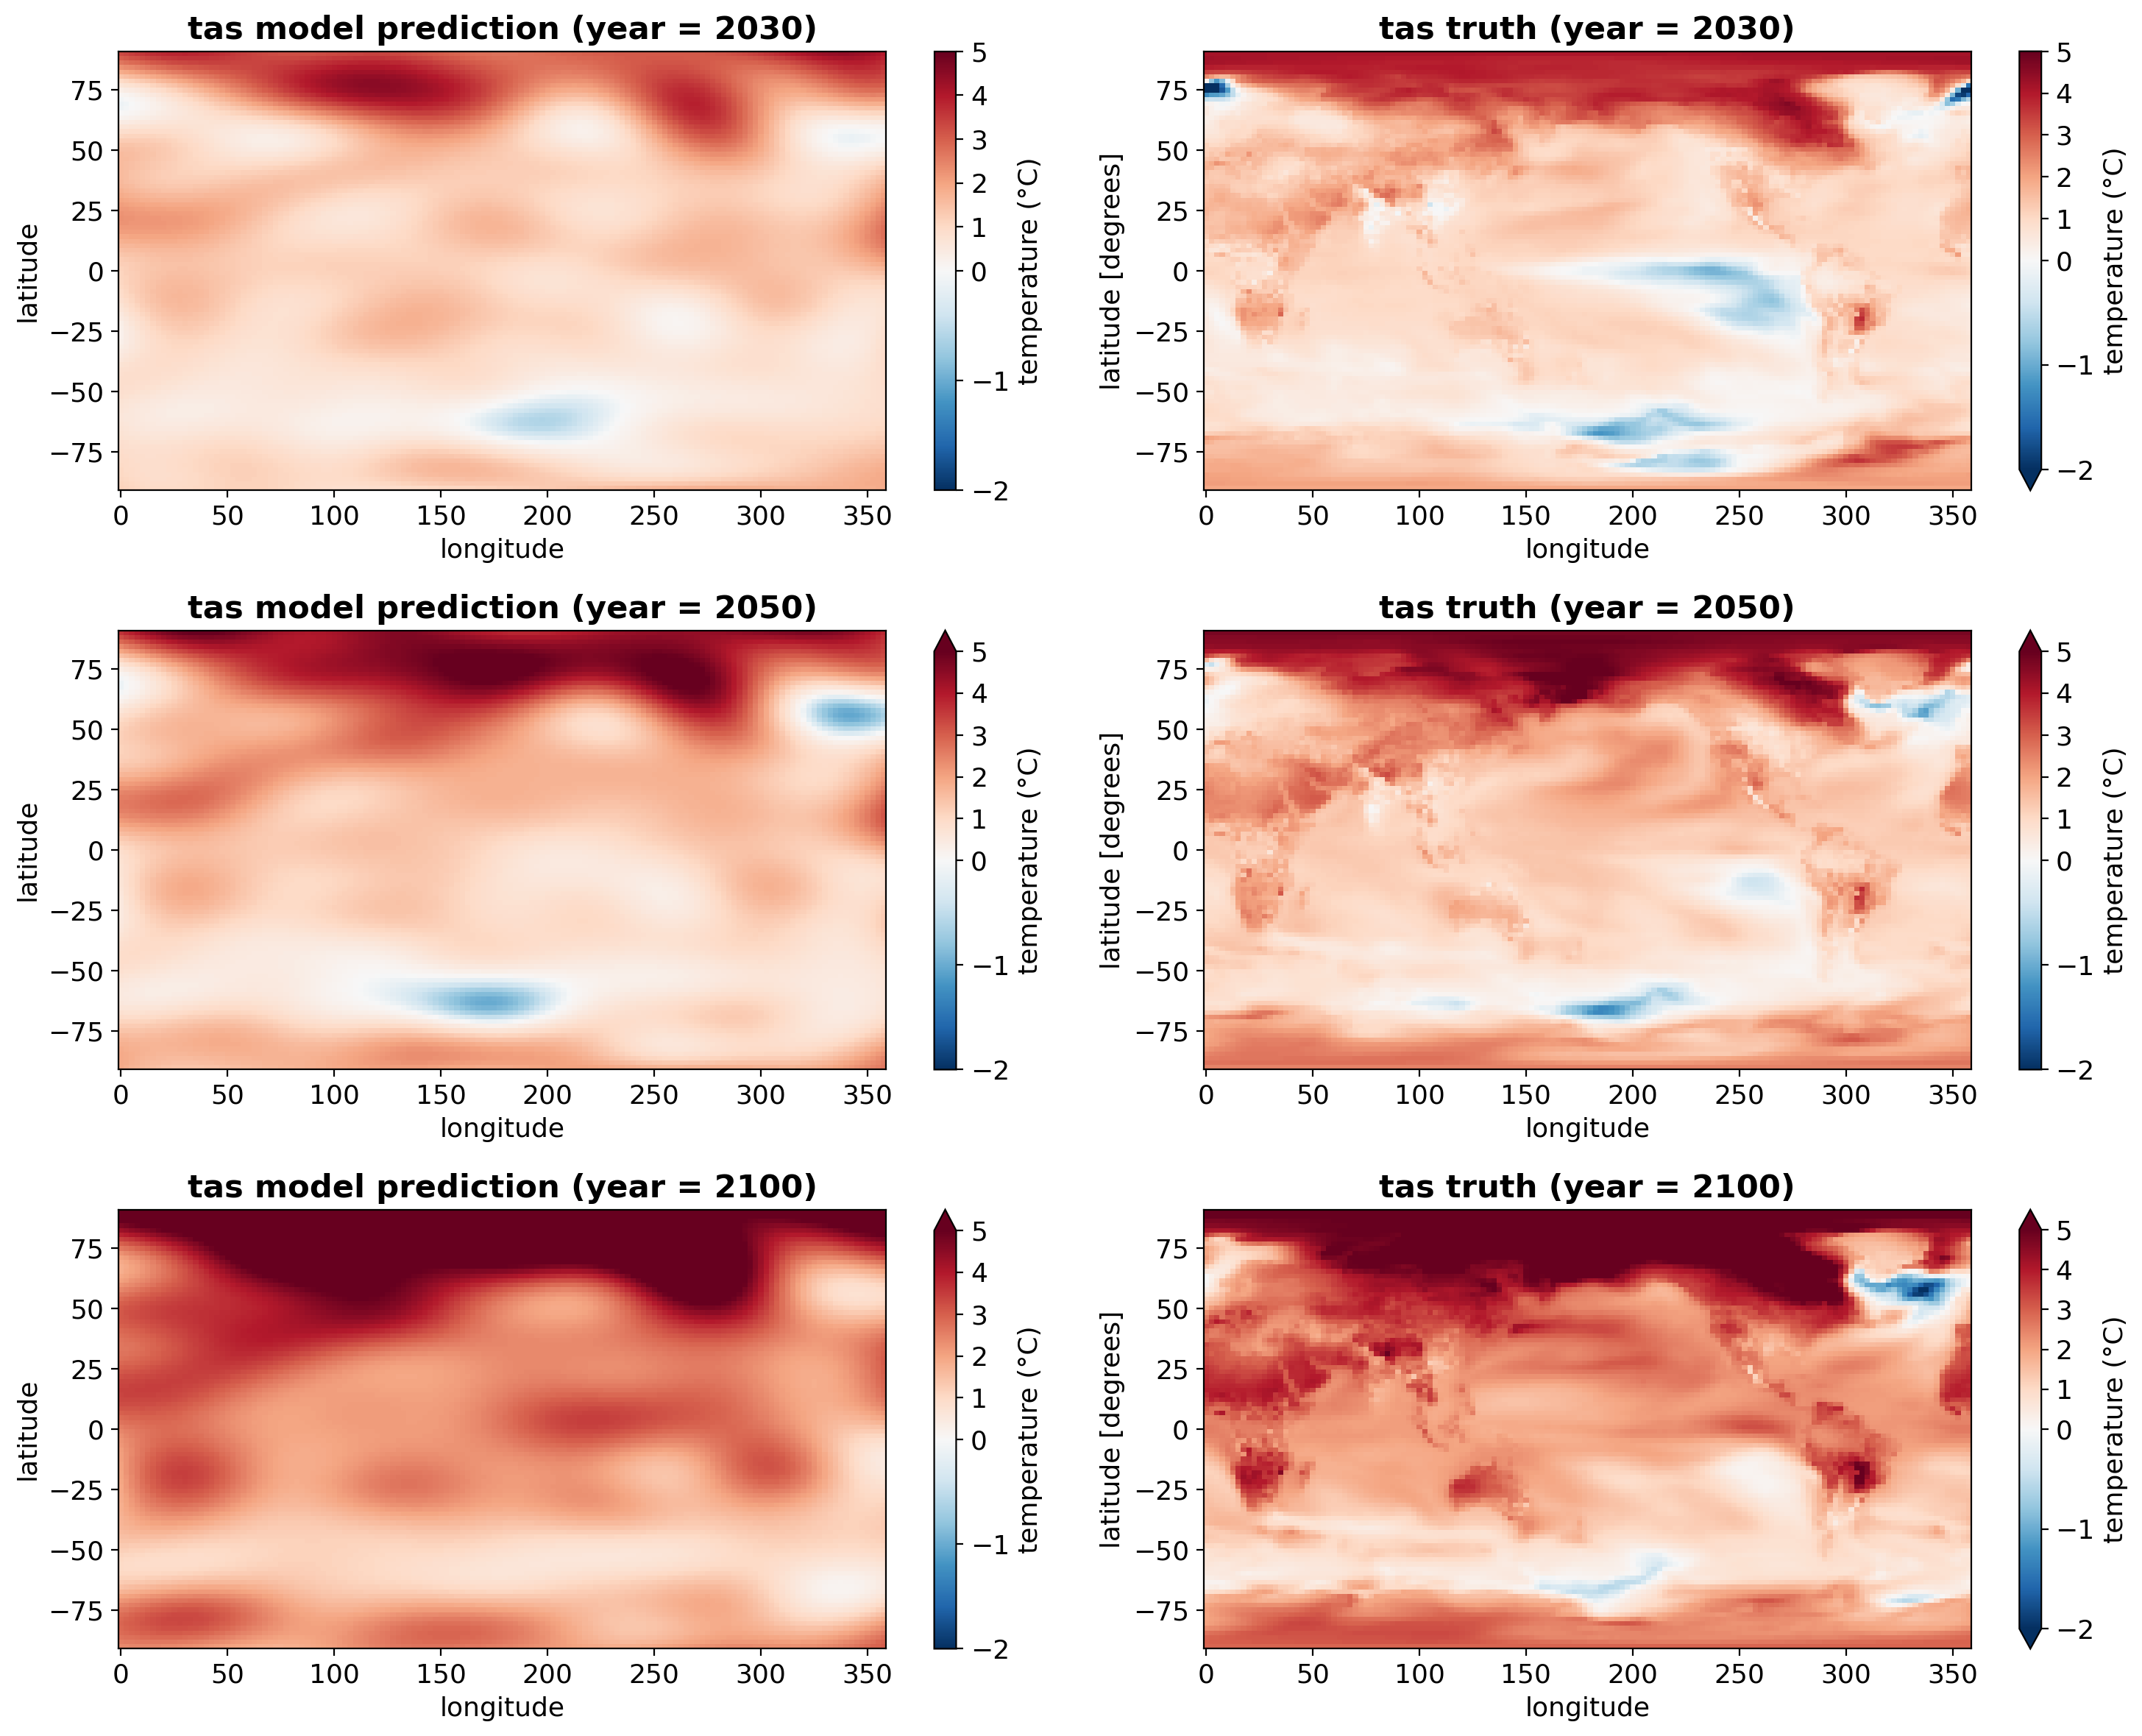

In [13]:
fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax = -2, 5
cmap = 'RdBu_r'
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

y_test_pre.tas_mean.sel(time=yrs[0]).plot(ax=axes[0, 0], cmap=cmap, norm=divnorm,
                                           cbar_kwargs={"label": "temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0, 1], cmap=cmap, norm=divnorm,
                                     cbar_kwargs={"label": "temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[1]).plot(ax=axes[1, 0], cmap=cmap, norm=divnorm,
                                           cbar_kwargs={"label": "temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1, 1], cmap=cmap, norm=divnorm,
                                     cbar_kwargs={"label": "temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[2]).plot(ax=axes[2, 0], cmap=cmap, norm=divnorm,
                                           cbar_kwargs={"label": "temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2, 1], cmap=cmap, norm=divnorm,
                                     cbar_kwargs={"label": "temperature (°C)"})

for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})', fontweight='bold')
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})', fontweight='bold')
plt.tight_layout()

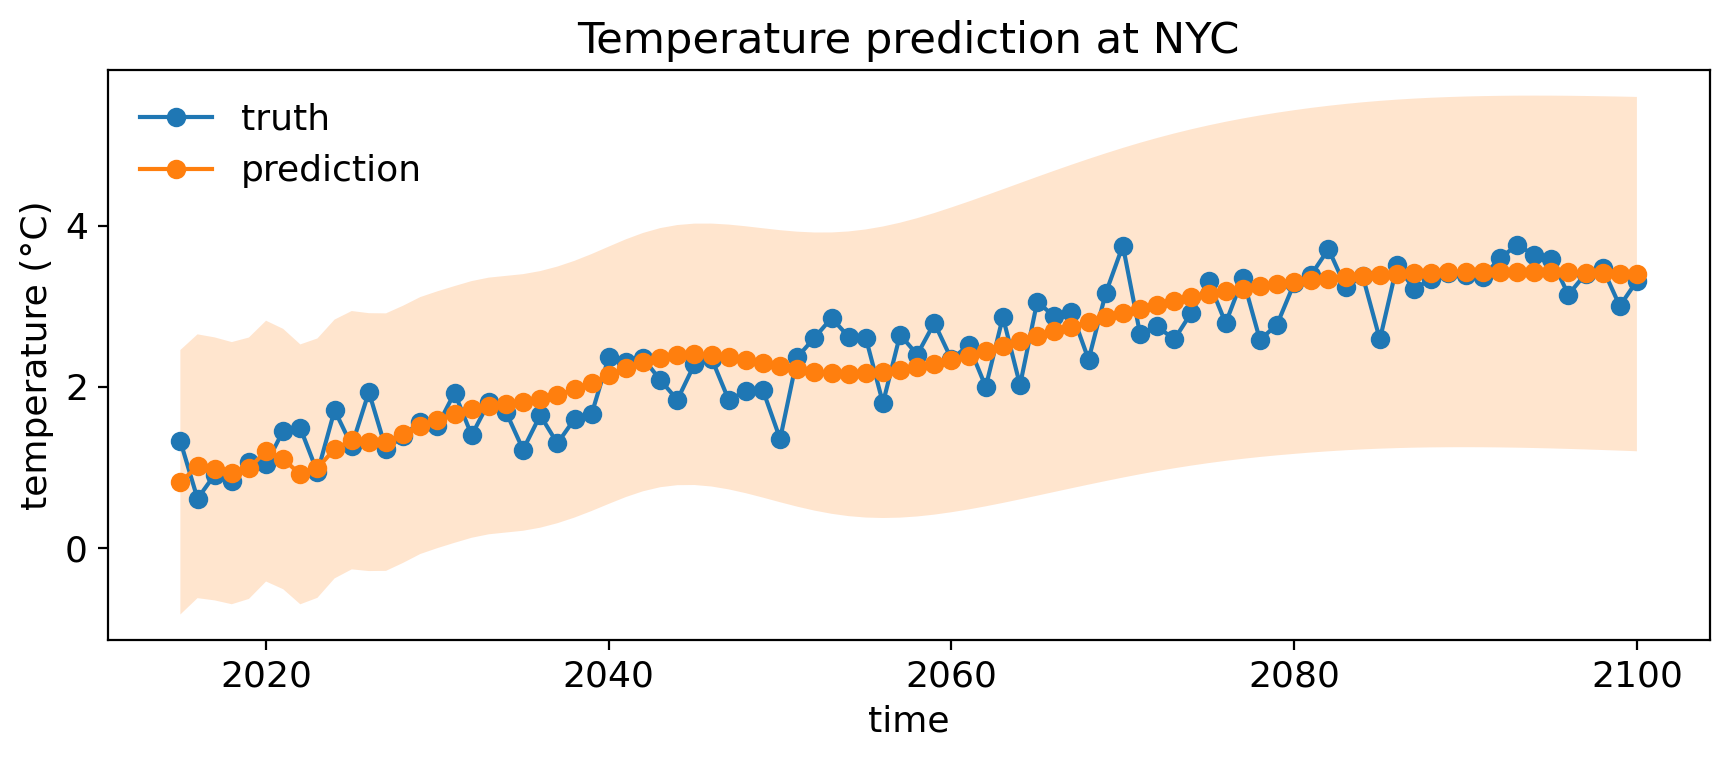

In [15]:
lat = 40.7128
lon = -74.0060 % 360

# Extract mean and std of air temperature prediction at NYC
y_test_pre_mean_nyc = y_test_pre["tas_mean"].sel(latitude=lat, longitude=lon, method='nearest').data
y_test_pre_std_nyc = y_test_pre["tas_std"].sel(latitude=lat, longitude=lon, method='nearest').data
y_test_pre_time = y_test_pre.time.data

# Plot
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest').tas.plot(
    marker='o', ax=ax, color='tab:blue', label='truth')
y_test_pre.sel(latitude=lat, longitude=lon, method='nearest').tas_mean.plot(
    marker='o', ax=ax, color='tab:orange', label='prediction')
ax.fill_between(y_test_pre_time,
                y_test_pre_mean_nyc + y_test_pre_std_nyc,
                y_test_pre_mean_nyc - y_test_pre_std_nyc,
                facecolor='tab:orange', alpha=0.2)

ax.legend()
ax.set_ylabel('temperature (°C)')
ax.set_title('Temperature prediction at NYC')
plt.tight_layout()